In [1]:
# !sudo apt install swig

In [2]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# Initializing

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd
import vmdpy

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Data Import and Preprocessing

In [4]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
print(len(TEST_SET))

##COVARIATE 1: PRICES

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (27180, 8)


In [5]:
##COVARIATES 2,3: VIX, FEAR/GREED INDEX

combined_spy_vix_fear_greed = pd.read_csv('datasets/VIX_feargreed/spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

In [6]:
##COVARIATE 4: STOCK HISTORICAL RATINGS

FMP_historical_ratings = pd.read_csv('datasets/historical_ratings/FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)

In [7]:
##COVARIATE 5: Macro Indicators

expenses = pd.read_csv('datasets/macro_indicators/expenses.csv')
gdp = pd.read_csv('datasets/macro_indicators/gdp.csv')
goods_services = pd.read_csv('datasets/macro_indicators/goods_and_services.csv')
pound_dollar = pd.read_csv('datasets/macro_indicators/pound-dollar-exchange-rate-historical-chart.csv')
unemployment = pd.read_csv('datasets/macro_indicators/unemployment.csv')
index_consumer_services = pd.read_csv('datasets/macro_indicators/index_consumer_services.csv')

df_portfolio_comb_2['date'] = pd.to_datetime(df_portfolio_comb_2['date'])
expenses['date'] = pd.to_datetime(unemployment['date'])
gdp['date'] = pd.to_datetime(gdp['DATE'])
goods_services['date'] = pd.to_datetime(goods_services['date'])
pound_dollar['date'] = pd.to_datetime(pound_dollar['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
index_consumer_services['date'] = pd.to_datetime(index_consumer_services['date'])

df_portfolio_comb_3 = pd.merge(df_portfolio_comb_2, expenses, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, gdp, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, goods_services, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, pound_dollar, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, unemployment, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, index_consumer_services, on='date', how='left')

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_3 = df_portfolio_comb_3.sort_values(by=['date', 'tic'])

# Forward fill missing data
df_portfolio_comb_3['expenses'] = df_portfolio_comb_3['expenses'].ffill()
df_portfolio_comb_3['GDP'] = df_portfolio_comb_3['GDP'].ffill()
df_portfolio_comb_3['exports'] = df_portfolio_comb_3['exports'].ffill()
df_portfolio_comb_3['imports'] = df_portfolio_comb_3['imports'].ffill()
df_portfolio_comb_3['pound_dollar_exchange_rate'] = df_portfolio_comb_3['pound_dollar_exchange_rate'].ffill()
df_portfolio_comb_3['unemployment'] = df_portfolio_comb_3['unemployment'].ffill()
df_portfolio_comb_3['ics'] = df_portfolio_comb_3['ics'].ffill()
df_portfolio_comb_3['net_export_goods_and_services'] = df_portfolio_comb_3['net_export_goods_and_services'].ffill()
df_portfolio_comb_3['exports_goods'] = df_portfolio_comb_3['exports_goods'].ffill()
df_portfolio_comb_3['exports_services'] = df_portfolio_comb_3['exports_services'].ffill()
df_portfolio_comb_3['imports_goods'] = df_portfolio_comb_3['imports_goods'].ffill()
df_portfolio_comb_3['imports_services'] = df_portfolio_comb_3['imports_services'].ffill()

df_portfolio_comb_3.drop(columns=['DATE'], inplace=True)

In [8]:
##COVARIATE 6: Fundamental Indicators

DBITDA_ratio = pd.read_csv('datasets/fundemental indicators/DBITDA_ratio.csv')
PB_ratio = pd.read_csv('datasets/fundemental indicators/PB_ratio.csv')
PE_ratio = pd.read_csv('datasets/fundemental indicators/PE_ratio.csv')
PS_ratio = pd.read_csv('datasets/fundemental indicators/PS_ratio.csv')
quarterly_data = pd.read_csv('datasets/fundemental indicators/quaterlydata.csv')
ROE = pd.read_csv('datasets/fundemental indicators/ROE.csv')

df_portfolio_comb_3['date'] = pd.to_datetime(df_portfolio_comb_3['date'])
DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
PS_ratio['date'] = pd.to_datetime(PS_ratio['date'])
quarterly_data['date'] = pd.to_datetime(quarterly_data['date'])
ROE['date'] = pd.to_datetime(ROE['date'])

df_portfolio_comb_4 = df_portfolio_comb_3

df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, DBITDA_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PB_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PE_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PS_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, quarterly_data, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, ROE, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_4 = df_portfolio_comb_4.sort_values(by=['tic', 'date'])

# Forward fill missing data
df_portfolio_comb_4['TTM Revenue(Billion)'] = df_portfolio_comb_4['TTM Revenue(Billion)'].ffill()
df_portfolio_comb_4['TTM EBITDA(Billion)'] = df_portfolio_comb_4['TTM EBITDA(Billion)'].ffill()
df_portfolio_comb_4['EBITDA Margin'] = df_portfolio_comb_4['EBITDA Margin'].ffill()
df_portfolio_comb_4['Price to Book Ratio'] = df_portfolio_comb_4['Price to Book Ratio'].ffill()
df_portfolio_comb_4['PE Ratio'] = df_portfolio_comb_4['PE Ratio'].ffill()
df_portfolio_comb_4['Price to Sales Ratio'] = df_portfolio_comb_4['Price to Sales Ratio'].ffill()
df_portfolio_comb_4['Assets'] = df_portfolio_comb_4['Assets'].ffill()
df_portfolio_comb_4['NetIncomeLoss'] = df_portfolio_comb_4['NetIncomeLoss'].ffill()
df_portfolio_comb_4['Return on Equity(%)'] = df_portfolio_comb_4['Return on Equity(%)'].ffill()
df_portfolio_comb_4['Book Value per Share'] = df_portfolio_comb_4['Book Value per Share'].ffill()
df_portfolio_comb_4['Net EPS'] = df_portfolio_comb_4['Net EPS'].ffill()
df_portfolio_comb_4['TTM Sales per Share'] = df_portfolio_comb_4['TTM Sales per Share'].ffill()
df_portfolio_comb_4['TTM Net Income (Billions)'] = df_portfolio_comb_4['TTM Net Income (Billions)'].ffill()
df_portfolio_comb_4['Shareholder\'s Equity (Billion)'] = df_portfolio_comb_4['Shareholder\'s Equity (Billion)'].ffill()


C:\Users\limyi\AppData\Local\Temp\ipykernel_25676\2437406948.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
C:\Users\limyi\AppData\Local\Temp\ipykernel_25676\2437406948.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
C:\Users\limyi\AppData\Local\Temp\ipykernel_25676\2437406948.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
C:\Users\limyi\AppData\Local\Temp\ipykernel_25676\2437406948.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the defa

In [9]:
## VMD
from vmdpy import VMD

def apply_vmd_to_ticker(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7):
    """Applies VMD to the 'close' price for each ticker in the dataframe
    and handles any length mismatch issues."""
    vmd_features = []
    
    # Apply VMD per ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Perform VMD on the close prices
        u, _, _ = VMD(close_prices, alpha, tau, K, DC, init, tol)
        
        # Check if the lengths match, and if not, align them
        if u.shape[1] != len(tic_df):
            print(f"Length mismatch for {tic}: VMD output has {u.shape[1]} points, expected {len(tic_df)}")
            min_len = min(u.shape[1], len(tic_df))
            tic_df = tic_df.iloc[:min_len]  # Truncate the dataframe to match VMD output length
            u = u[:, :min_len]  # Truncate VMD output if necessary
        
        # Assign VMD modes to columns
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = u[k, :]
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df
#apply VMD separately to each train, 2021, 2022, 2023 data
df_portfolio_comb_5 = apply_vmd_to_ticker(df_portfolio_comb_4)

In [10]:
from vmdpy import VMD
import pandas as pd
import numpy as np

def apply_vmd_to_ticker_rolling(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7, window=365):
    """
    Applies VMD to the 'close' price for each ticker in the dataframe using a rolling window approach.
    This ensures that each VMD decomposition is based only on the previous `window` ticks, avoiding forward leakage.
    
    Args:
        df (pd.DataFrame): Dataframe containing 'close' price data and 'tic' column.
        alpha, tau, K, DC, init, tol: Parameters for the VMD decomposition.
        window (int): Number of previous ticks to use for the rolling VMD.

    Returns:
        pd.DataFrame: DataFrame with the VMD modes added for each ticker.
    """
    vmd_features = []
    
    # Apply VMD for each ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Initialize empty columns for VMD modes
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = np.nan  # Initialize with NaNs

        # Apply VMD in a rolling window manner
        for i in range(window, len(close_prices)):
            close_window = close_prices[i - window:i]  # Select the previous `window` close prices
            
            # Perform VMD on the window of close prices
            u, _, _ = VMD(close_window, alpha, tau, K, DC, init, tol)
            
            # Assign the latest VMD modes (from the last tick of the window) to the current row
            for k in range(K):
                tic_df.at[tic_df.index[i], f'vmd_mode_{k}'] = u[k, -1]  # Assign last mode from the VMD result
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df

df_portfolio_comb_5 = apply_vmd_to_ticker_rolling(df_portfolio_comb_4)


In [11]:
df_portfolio_final = df_portfolio_comb_5

In [12]:
# Check the data types of all columns in the DataFrame
print(df_portfolio_final.dtypes)

date                              datetime64[ns]
open                                     float64
high                                     float64
low                                      float64
close                                    float64
volume                                     int64
tic                                       object
day                                        int32
Open_VIX                                 float64
High_VIX                                 float64
Low_VIX                                  float64
Close_VIX                                float64
Adj Close_VIX                            float64
Open_SPY                                 float64
High_SPY                                 float64
Low_SPY                                  float64
Close_SPY                                float64
Adj Close_SPY                            float64
Volume_SPY                               float64
Fear Greed                               float64
ratingScore         

In [13]:
#Convert Str to Float64
df_portfolio_final['net_export_goods_and_services'] = df_portfolio_final['net_export_goods_and_services'].str.replace(',', '').astype('float64')
df_portfolio_final['expenses'] = df_portfolio_final['expenses'].str.replace(',', '').astype('float64')
df_portfolio_final['exports'] = df_portfolio_final['exports'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_goods'] = df_portfolio_final['exports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_services'] = df_portfolio_final['exports_services'].str.replace(',', '').astype('float64')
df_portfolio_final['imports'] = df_portfolio_final['imports'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_goods'] = df_portfolio_final['imports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_services'] = df_portfolio_final['imports_services'].str.replace(',', '').astype('float64')

#Convert rest to Float64
df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])] = df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])].astype('float64')

#Convert date back
df_portfolio_final['date'] = df_portfolio_final['date'].dt.strftime('%Y-%m-%d')

In [14]:
# Filling NaN values with 0
df_portfolio_final.fillna(0, inplace=True)

In [15]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_final)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,Open_VIX,High_VIX,...,TTM Sales per Share,Price to Sales Ratio,Assets,NetIncomeLoss,TTM Net Income (Billions),Shareholder's Equity (Billion),Return on Equity(%),vmd_mode_0,vmd_mode_1,vmd_mode_2
0,2014-01-02,0.083921,0.083767,0.084245,0.073418,0.220253,AAPL,0.75,0.173177,0.170703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
10,2014-01-03,0.083495,0.083267,0.082476,0.071805,0.368333,AAPL,1.00,0.170033,0.166374,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
20,2014-01-06,0.081168,0.082229,0.081434,0.072197,0.387238,AAPL,0.00,0.162172,0.163800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
30,2014-01-07,0.082206,0.082103,0.082093,0.071681,0.297703,AAPL,0.25,0.149716,0.155376,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
40,2014-01-08,0.081374,0.082043,0.082211,0.072135,0.242632,AAPL,0.50,0.157697,0.154908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27139,2024-10-14,0.983952,0.983537,0.982060,0.989710,0.116155,XOM,0.00,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.991196,0.051525,0.026978
27149,2024-10-15,0.964631,0.965252,0.959314,0.959958,0.186777,XOM,0.25,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.994699,0.017176,-0.034284
27159,2024-10-16,0.965190,0.961216,0.965882,0.962431,0.099797,XOM,0.50,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.998238,-0.010744,0.019620
27169,2024-10-17,0.964152,0.962324,0.958754,0.959958,0.132685,XOM,0.75,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.999128,-0.063793,-0.011991


In [16]:
df_portfolio = portfolio_norm_df[["date", 
                                  "tic", 
                                  "close",
                                  "vmd_mode_0",
                                 "vmd_mode_1",
                                 "vmd_mode_2",
                                  "high", 
                                  "low",
                                  'High_VIX',
                                  'Low_VIX',
                                  'Close_VIX',
                                  'High_SPY',
                                  'Low_SPY',
                                  'Close_SPY',
                                  'Volume_SPY',
                                  'Fear Greed', 
                                  'ratingScore',
                                  'ratingDetailsDCFScore',
                                  'ratingDetailsROEScore',
                                  'ratingDetailsROAScore',
                                  'ratingDetailsPEScore',
                                  'ratingDetailsPBScore',
                                  'expenses',
                                  'GDP', 
                                  'exports', 
                                  'imports',
                                  'pound_dollar_exchange_rate', 
                                  'unemployment',
                                  'ics',
                                  'TTM Revenue(Billion)',
                                  'TTM EBITDA(Billion)',
                                  'EBITDA Margin',
                                  'Price to Book Ratio',
                                  'PE Ratio',
                                  'Price to Sales Ratio',
                                  'Assets',
                                  'NetIncomeLoss',
                                  'Return on Equity(%)']]

In [17]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_test = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [18]:
# #save as parquet
# df_portfolio_train.to_parquet('datasets/df_portfolio_train.parquet')
# df_portfolio_2021.to_parquet('datasets/df_portfolio_2021.parquet')
# df_portfolio_2022.to_parquet('datasets/df_portfolio_2022.parquet')
# df_portfolio_2023.to_parquet('datasets/df_portfolio_2023.parquet')


## Load data and Initialise Packages
If loading data start here.

In [19]:
# import logging
# logging.getLogger('matplotlib.font_manager').disabled = True
# import torch

# import numpy as np
# import pandas as pd

# from sklearn.preprocessing import MaxAbsScaler
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# from finrl.meta.preprocessor.preprocessors import GroupByScaler
# from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
# from finrl.agents.portfolio_optimization.models import DRLAgent
# from finrl.agents.portfolio_optimization.architectures import EIIE

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # Load the data
# df_portfolio_train = pd.read_parquet('datasets/df_portfolio_train.parquet')
# df_portfolio_2021 = pd.read_parquet('datasets/df_portfolio_2021.parquet')
# df_portfolio_2022 = pd.read_parquet('datasets/df_portfolio_2022.parquet')
# df_portfolio_2023 = pd.read_parquet('datasets/df_portfolio_2023.parquet')

In [20]:
# df_portfolio_2021.head()

# Feature Selection and DRL Model Parameters

In feature_selection.ipynb, we perform a regression of parameters on close prices with LassoCV, and then inspect the coefficients to make a preliminary selection of the most efficient subset of features to include in our DRL model.

The selected features are: 

- High_VIX, Low_VIX, High_SPY, Low_SPY, Close_SPY, 
- Fear Greed, ratingScore, ratingDetailsROEScore, 
- exports, pound_dollar_exchange_rate, unemployment, ics,
- TTM Revenue(Billion), Price to Book Ratio, Price to Sales Ratio, Return on Equity(%)

In [21]:
FEATURE_NAMES = ["close",
               "vmd_mode_0",
                "vmd_mode_1",
                "vmd_mode_2",
                  #"high", 
                  #"low",
                'High_VIX',
                'Low_VIX',
                  #'Close_VIX',
                'High_SPY',
                'Low_SPY',
                'Close_SPY',
                  #'Volume_SPY',
                'Fear Greed', 
                'ratingScore',
                  #'ratingDetailsDCFScore',
                'ratingDetailsROEScore',
                  #'ratingDetailsROAScore',
                  #'ratingDetailsPEScore',
                  #'ratingDetailsPBScore',
                  #'expenses',
                  #'GDP', 
                'exports', 
                  #'imports',
                'pound_dollar_exchange_rate', 
                'unemployment',
                'ics',
                'TTM Revenue(Billion)',
                  #'TTM EBITDA(Billion)',
                  #'EBITDA Margin',
                'Price to Book Ratio',
                  #'PE Ratio',
                'Price to Sales Ratio',
                  #'Assets',
                  #'NetIncomeLoss',
                'Return on Equity(%)']

TIME_WINDOW = 50
COMISSION_FEE = 0.0025
K_SIZE = 4
CONV_MID = 5
CONV_FINAL= 10

environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features":CONV_MID,
    "conv_final_features":CONV_FINAL}

EIIE_model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

# DRL Model Training (Jan 2014- Dec 2022)

In [22]:
DRLAgent.train_model(EIIE_model, episodes=10)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE.pt")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 283131.21875
Final accumulative portfolio value: 2.8313121875
Maximum DrawDown: -0.3186898969119093
Sharpe ratio: 0.7342075043597488


 10%|████████▎                                                                          | 1/10 [00:23<03:33, 23.70s/it]

Initial portfolio value:100000
Final portfolio value: 455781.78125
Final accumulative portfolio value: 4.5578178125
Maximum DrawDown: -0.34758696395036937
Sharpe ratio: 0.9565205462699145


 20%|████████████████▌                                                                  | 2/10 [00:47<03:10, 23.77s/it]

Initial portfolio value:100000
Final portfolio value: 1116890.625
Final accumulative portfolio value: 11.16890625
Maximum DrawDown: -0.36106743447896195
Sharpe ratio: 1.1562415437835376


 30%|████████████████████████▉                                                          | 3/10 [01:11<02:46, 23.77s/it]

Initial portfolio value:100000
Final portfolio value: 1678989.125
Final accumulative portfolio value: 16.78989125
Maximum DrawDown: -0.38181525953457085
Sharpe ratio: 1.2761938483047317


 40%|█████████████████████████████████▏                                                 | 4/10 [01:35<02:23, 23.91s/it]

Initial portfolio value:100000
Final portfolio value: 1798945.875
Final accumulative portfolio value: 17.98945875
Maximum DrawDown: -0.38470848703620375
Sharpe ratio: 1.3075718654329875


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:59<02:00, 24.11s/it]

Initial portfolio value:100000
Final portfolio value: 2190841.75
Final accumulative portfolio value: 21.9084175
Maximum DrawDown: -0.3842186146083518
Sharpe ratio: 1.3767967468692235


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:24<01:36, 24.15s/it]

Initial portfolio value:100000
Final portfolio value: 1893333.0
Final accumulative portfolio value: 18.93333
Maximum DrawDown: -0.3850642652442996
Sharpe ratio: 1.3086903657266558


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:48<01:12, 24.12s/it]

Initial portfolio value:100000
Final portfolio value: 2399406.25
Final accumulative portfolio value: 23.9940625
Maximum DrawDown: -0.3846543077378157
Sharpe ratio: 1.4035033266217203


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:12<00:48, 24.11s/it]

Initial portfolio value:100000
Final portfolio value: 2121332.75
Final accumulative portfolio value: 21.2133275
Maximum DrawDown: -0.3832146210381071
Sharpe ratio: 1.361363637000158


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:36<00:24, 24.15s/it]

Initial portfolio value:100000
Final portfolio value: 2388713.25
Final accumulative portfolio value: 23.8871325
Maximum DrawDown: -0.38462176955316085
Sharpe ratio: 1.414300142478465


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.06s/it]


# DRL Model Evaluation (Jan 2023-Oct 2024)

In [23]:
import os
import shutil

environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)


EIIE_results = {
    "train": {},
    "test": {} }

# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\limyi\AppData\Local\Temp\ipykernel_25676\4224154994.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

Initial portfolio value:100000
Final portfolio value: 1853387.125
Final accumulative portfolio value: 18.53387125
Maximum DrawDown: -0.3851178703324154
Sharpe ratio: 1.3196332190583062
Initial portfolio value:100000
Final portfolio value: 170744.078125
Final accumulative portfolio value: 1.70744078125
Maximum DrawDown: -0.18609110735492285
Sharpe ratio: 1.8542230200846372
Initial portfolio value:100000
Final portfolio value: 339681.0
Final accumulative portfolio value: 3.39681
Maximum DrawDown: -0.3532227264766419
Sharpe ratio: 0.8385010812798463
Initial portfolio value:100000
Final portfolio value: 137178.140625
Final accumulative portfolio value: 1.37178140625
Maximum DrawDown: -0.09963546347165042
Sharpe ratio: 1.9127595556388717


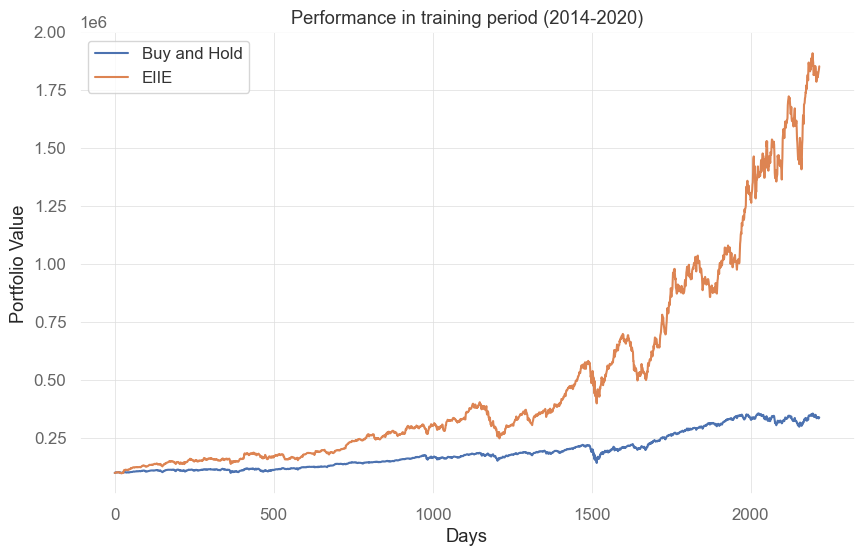

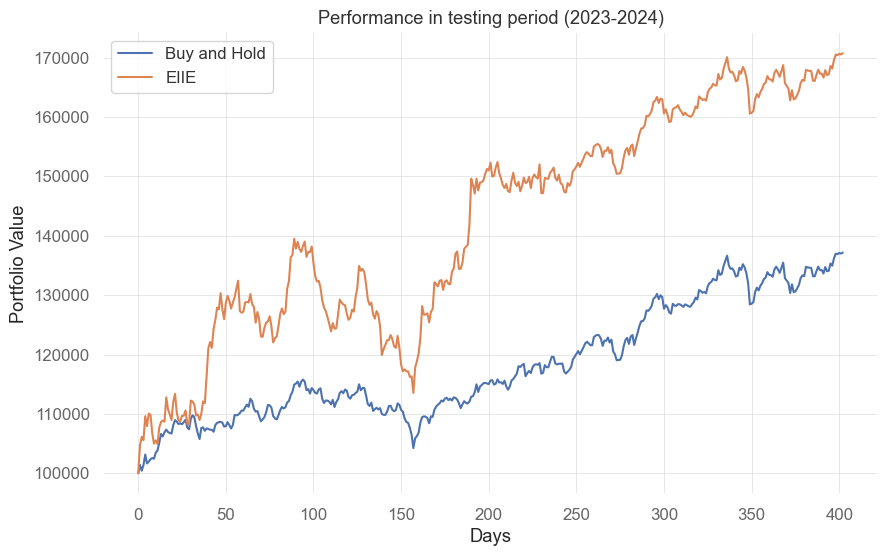

In [24]:
# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', 'train_drawdown', 'train_sharpe', 'train_cumulative',
          'test_portfolio_value', 'test_drawdown', 'test_sharpe', 'test_cumulative']

results_df = pd.DataFrame(columns=columns)

environment.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(environment)

src_folder = "results/rl"
dst_folder = "results/test"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_test, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["test"]["value"] = environment_test._asset_memory["final"]
EIIE_results["test"]["actions"] = environment_test._actions_memory
portfolio_test_value, drawdown_test, sharpe_test, cumulative_test = calculate_metrics(environment_test)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "test": {"value": [], "actions": []} }


PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]


# test
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
    UBAH_results["test"]["actions"].append(action)
UBAH_results["test"]["value"] = environment_test._asset_memory["final"]


import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period (2014-2020)")
plt.legend()

plt.show()

plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period (2023-2024)")
plt.legend()

plt.show()

# Portfolio Allocation by Trained DRL Model

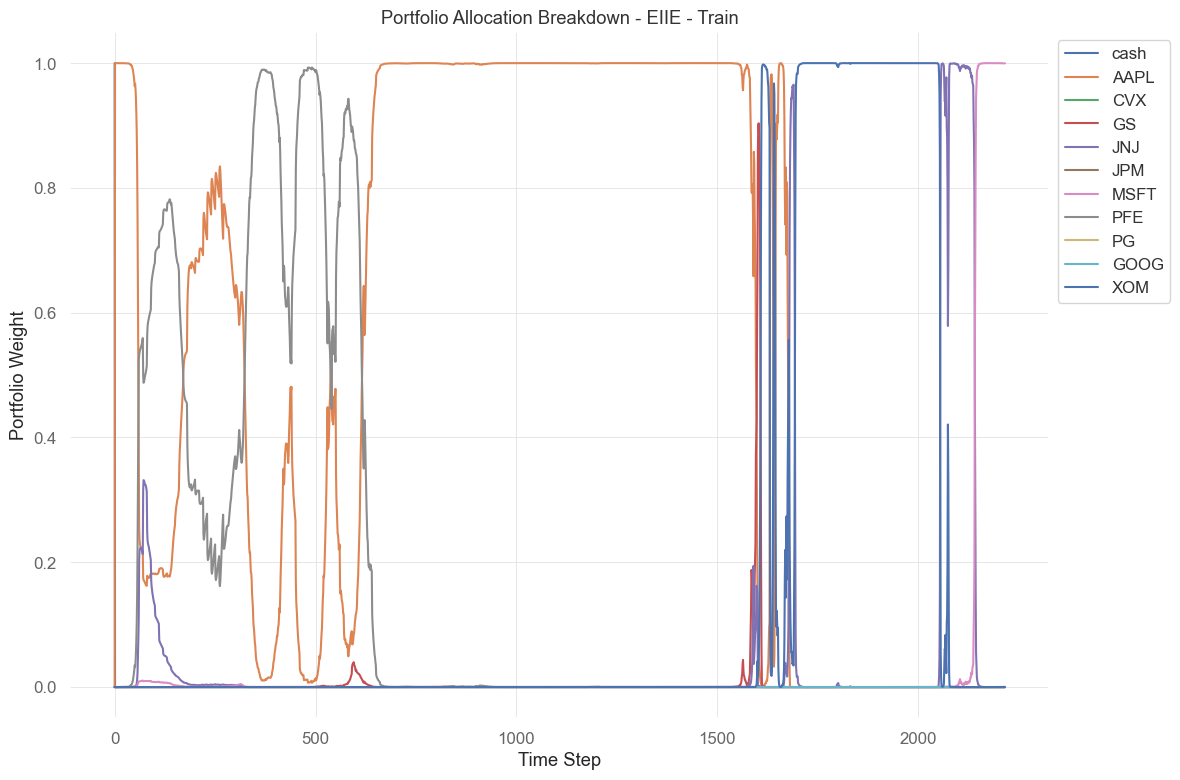

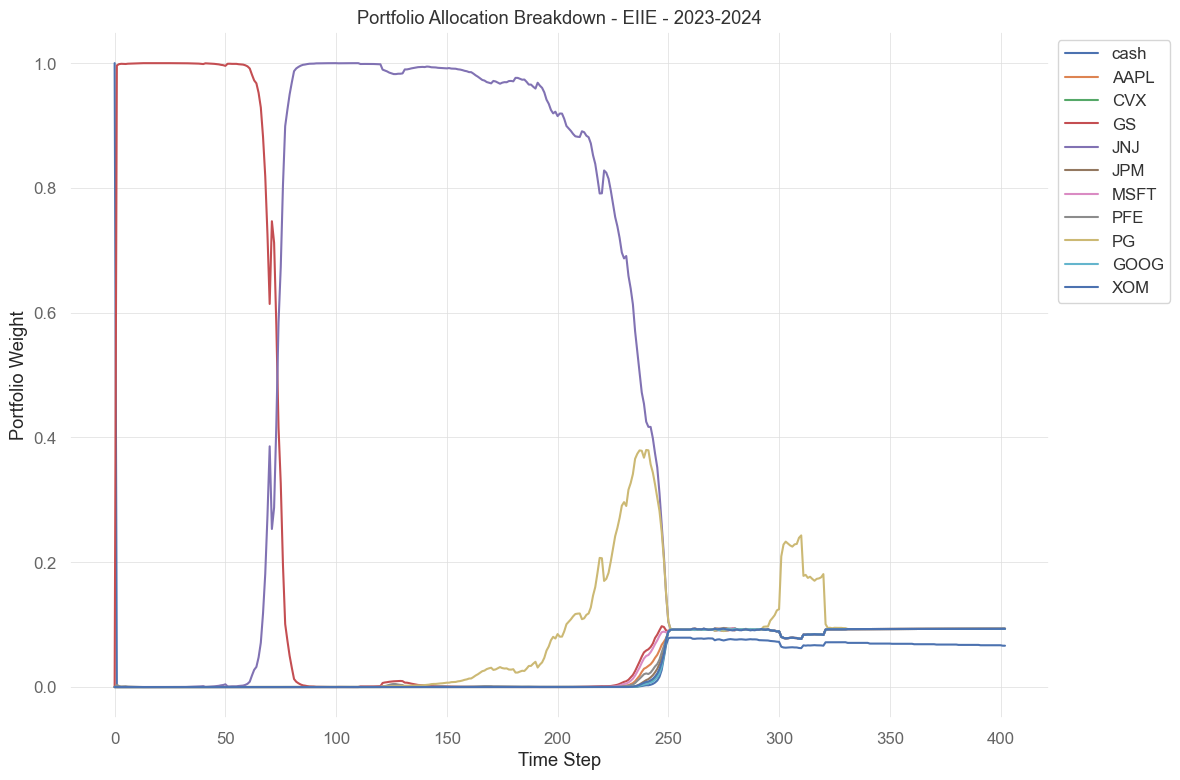

C:\Users\limyi\AppData\Local\Temp\ipykernel_25676\2754751428.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,train_portfolio_value,train_drawdown,train_sharpe,train_cumulative,test_portfolio_value,test_drawdown,test_sharpe,test_cumulative
0,50,4,5,10,1853387.125,-0.385118,1.320231,18.533871,170744.078125,-0.186091,1.858867,1.707441


In [25]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for test
plot_action_memory(EIIE_results["test"]["actions"], TEST_SET, "EIIE - 2023-2024")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")

temp_df = pd.DataFrame([{
        "TIME_WINDOW": TIME_WINDOW, "K_SIZE": K_SIZE, "CONV_MID": CONV_MID, "CONV_FINAL": CONV_FINAL,
        "train_portfolio_value": train_final_value, "train_drawdown": train_drawdown, "train_sharpe": train_sharpe, "train_cumulative": train_cumulative,
        "test_portfolio_value": portfolio_test_value, "test_drawdown": drawdown_test, "test_sharpe": sharpe_test, "test_cumulative": cumulative_test}]
)
results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
results_df

In [27]:
results_df.to_csv('filename.csv', index=False)